In [180]:
using JuMP, PyPlot, NamedArrays

In [169]:
# Create a plot showing the request with the time window
function plot_Request_Time_Window(passengers)
    figure();
    request_no = length(passengers)
    drop_time_list = []

    for i=1:request_no
        p = passengers[i]
        drop_time = p.pickup_time + p.duration
        push!(drop_time_list, drop_time)
        
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        hlines(y=i, xmin=p.pickup_time, xmax=drop_time, color=color_val)
        plot(p.pickup_time, i, marker="o", color=color_val)
        plot(drop_time, i, marker="o", color=color_val)
        
        time_stamp = string("T = ", p.pickup_time)
        text(p.pickup_time, i + 0.1, time_stamp, fontsize=8)
        time_stamp = string("T = ", drop_time)
        text(drop_time, i - 0.2, time_stamp, fontsize=8) 
    end

    PyPlot.yticks(1:request_no)
    ax = gca()
    ax[:set_xlim](passengers[1].pickup_time - 10, maximum(drop_time_list) + 20)
    ax[:set_ylim]([0, request_no + 1])
    title("Request vs Time")
    xlabel("Time")
    ylabel("Request #")
    grid("on")
end

plot_Request_Time_Window (generic function with 1 method)

In [170]:
using PyPlot
WIDTH = 51 # odd number
HEIGHT = 41 # odd number
NRG = min(WIDTH, HEIGHT)

type Passenger
    pickup_pos::Tuple{Int64, Int64}
    pickup_time::Int
    dropoff_pos::Tuple{Int64, Int64}
    duration::Int
end
type Driver
    cur_pos::Tuple{Int64, Int64}
end

function manhattan_distance(a, b)
    return sum(abs.([i for i in a]-[i for i in b]))
end

function rand_xy()
   return (rand(1:WIDTH), rand(1:HEIGHT)) 
end


function rand_normalized_xy()
    pass_x = Int(round((randn()/6+0.5)*(NRG-1)+1))
    pass_y = Int(round((randn()/6+0.5)*(NRG-1)+1))
    if WIDTH > HEIGHT
        pass_x += Int(round((WIDTH-HEIGHT)/2))
    else
        pass_y += Int(round((HEIGHT-WIDTH)/2))
    end
    return (pass_x, pass_y)
end


rand_normalized_xy (generic function with 1 method)

In [181]:
function plot_passenger_driver(passengers, drivers)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[] # driver current position x
    dys = Int64[] # driver current position y
    fig = figure("pyplot_scatterplot",figsize=(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(passengers)
        p = passengers[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.3)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.3)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(drivers)
        d = drivers[i]
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="r")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="g")
    scatter(dxs,dys,s=300,alpha=0.5,color="b")
    
    title("Map")
    xlabel("X");xlim([1,WIDTH])
    ylabel("Y");ylim([1,HEIGHT])
    grid("on")
end


plot_passenger_driver (generic function with 1 method)

In [182]:
function genGrid(n_passenger, n_driver)
    passengers = Passenger[]
    drivers = Driver[]
    ptime = sort(rand(50:200,n_passenger))  #############################################################
    for i=1:n_passenger
        ppos = rand_xy()
        dpos = rand_xy()
        p = Passenger(ppos, ptime[i], dpos, manhattan_distance(ppos,dpos))
        push!(passengers, p)
    end
    for i=1:n_driver
        d = Driver((Int((WIDTH+1)/2), Int((HEIGHT+1)/2)))
        push!(drivers, d)
    end
    plot_passenger_driver(passengers, drivers)
    for p in passengers
        println(p)
    end
    #plot_Request_Time_Window(passengers)   ############## Modifying this to be called after distance matrix is computed.
    return passengers,drivers
end

genGrid (generic function with 1 method)

In [183]:
# Function to Get the coordinates of all depot and pickup, drop locations of requests (in order of request)
# Can be modified to be called within distance matrix

function get_locations(depot, requests)
    nodes = []
    for d in depot             # Right now, considering only single depot.
        depot_node = d.cur_pos
        push!(nodes, depot_node)
    end

    for r in requests
        push!(nodes, r.pickup_pos)
        push!(nodes, r.dropoff_pos)
    end
    return nodes
end

get_locations (generic function with 1 method)

In [184]:
# Generating distance matrix.
 
function distance_matrix(nodes, numReq)
    
    # Creating names for nodes
    numReq = length(requests)
    points = []
    i = 0
    push!(points,"Depot")
    for r in 1:numReq
        i = i+1
        pickup = string("P_",i)
        drop = string("D_",i)
        push!(points,pickup)
        push!(points,drop)
    end
    println(points)

    # Compute distance matrix for the Agencies
    pointA = nodes
    pointB = copy(nodes)

    nodeLen = length(nodes) # nodes include pickup, dropoff and depot

    D = zeros(nodeLen,nodeLen)

    for j = 1:nodeLen
            for i = 1:nodeLen
                D[i, j] = abs(pointA[j][1] - pointB[i][1]) + abs(pointA[j][2] - pointB[i][2])
            end
    end
    #println("Distance matrix : ",D)
    println("")

    dist_matrix =  NamedArray(D,(points,points),("From","To"))
    show(IOContext(STDOUT, displaysize=(2000, 2000)), dist_matrix)
    
    println("\n")
    return dist_matrix
end

distance_matrix (generic function with 1 method)

In [189]:
# Function to assign random request times for each request

function assign_pickup_time(startT, requests)
    endT = startT + 200
    ptime = sort(rand(startT:endT, length(requests)))
    #println(ptime)
    k = 1
    for r in requests
        r.pickup_time = ptime[k]
        k = k + 1
    end
    return requests
end

assign_pickup_time (generic function with 1 method)

#   Start here calling functions : 

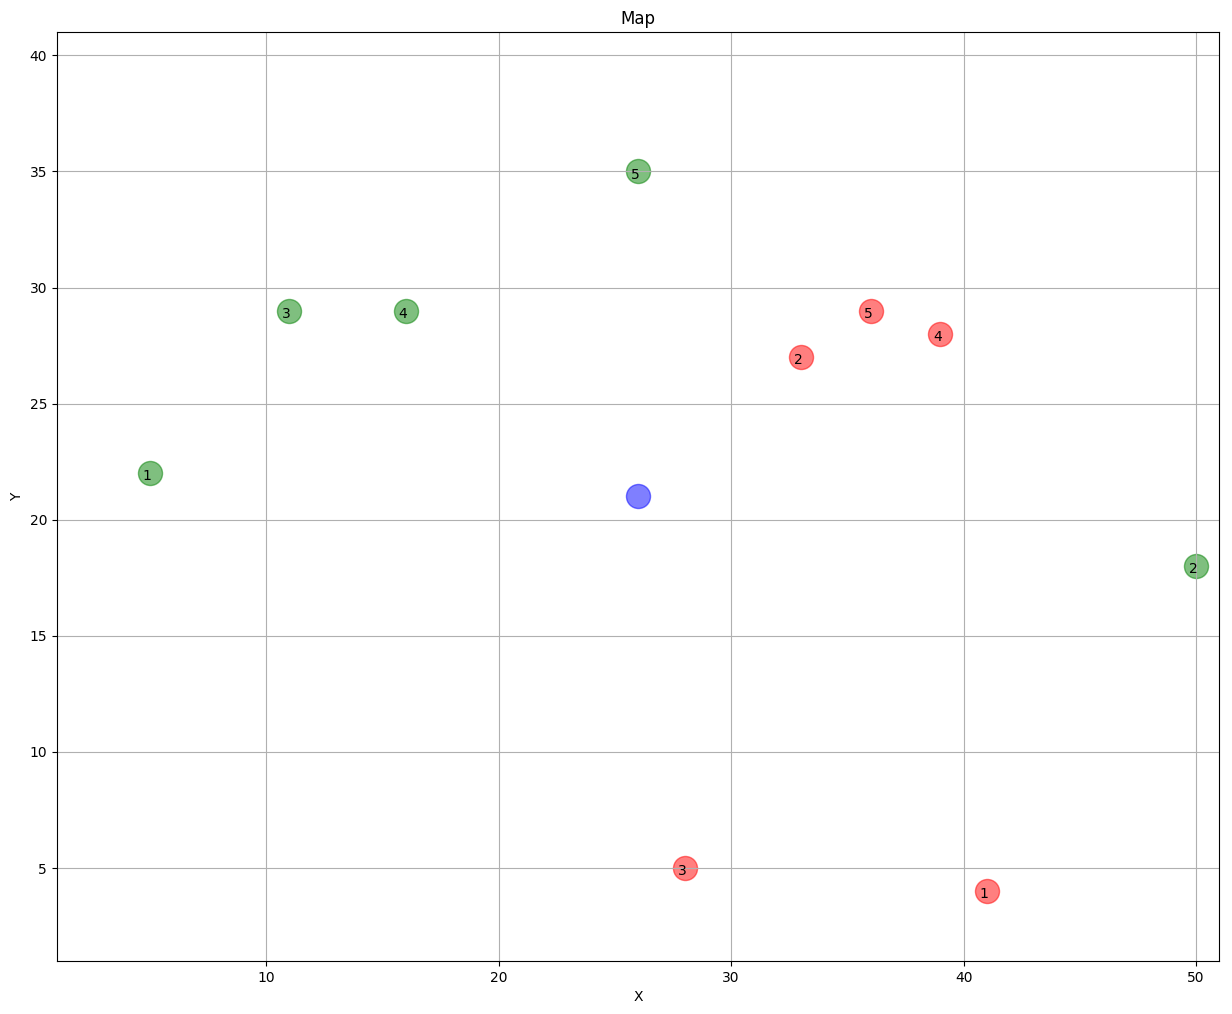

Passenger((41, 4), 138, (5, 22), 54)
Passenger((33, 27), 150, (50, 18), 26)
Passenger((28, 5), 156, (11, 29), 41)
Passenger((39, 28), 164, (16, 29), 24)
Passenger((36, 29), 186, (26, 35), 16)


In [190]:
# Generate all input data
requests, depot = genGrid(5,1)
;

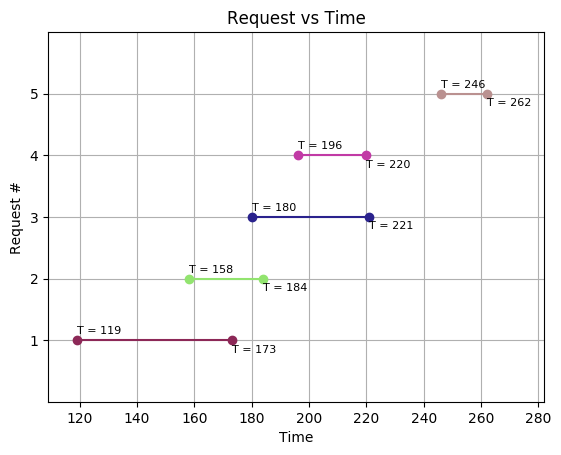

Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3", "P_4", "D_4", "P_5", "D_5"]

11×11 Named Array{Float64,2}
From ╲ To │ Depot    P_1    D_1    P_2    D_2    P_3    D_3    P_4    D_4    P_5    D_5
──────────┼────────────────────────────────────────────────────────────────────────────
Depot     │   0.0   32.0   22.0   13.0   27.0   18.0   23.0   20.0   18.0   18.0   14.0
P_1       │  32.0    0.0   54.0   31.0   23.0   14.0   55.0   26.0   50.0   30.0   46.0
D_1       │  22.0   54.0    0.0   33.0   49.0   40.0   13.0   40.0   18.0   38.0   34.0
P_2       │  13.0   31.0   33.0    0.0   26.0   27.0   24.0    7.0   19.0    5.0   15.0
D_2       │  27.0   23.0   49.0   26.0    0.0   35.0   50.0   21.0   45.0   25.0   41.0
P_3       │  18.0   14.0   40.0   27.0   35.0    0.0   41.0   34.0   36.0   32.0   32.0
D_3       │  23.0   55.0   13.0   24.0   50.0   41.0    0.0   29.0    5.0   25.0   21.0
P_4       │  20.0   26.0   40.0    7.0   21.0   34.0   29.0    0.0   24.0    4.0   20.0
D_4    

In [192]:
# Get Location coordinates.
nodes = get_locations(depot, requests)

# Compute distance matrix
dist_matrix = distance_matrix(nodes, length(requests))

# Find max distance from the depot to a pickup and use it as the reference time to start the TimeSlots for requests
maxDistFromDepot = maximum(dist_matrix)

# Now, assign random time slots beginning from maxDistFromDepot to all requests.
requests = assign_pickup_time(maxDistFromDepot, requests)

plot_Request_Time_Window(requests)   # Calling this function here coz of modified slots.